# Распознавание ключевых слов: использование речевых формант в качестве входных параметров модели 

Пример ноутбука, распознающего слова "down", "go", "left", "no", "right", "stop", "up", "yes", используя форманты в качестве фичей

## Установка библиотек

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from sklearn import preprocessing as skl_prepr

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from scipy.signal import find_peaks

import python_speech_features as psf

from pydub import AudioSegment

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
print(tf.__version__, np.__version__)

2.7.0 1.19.5


## Импорт датасета Google Speech Commands

Используется малый датасет для настройки алгоритма

In [3]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Shuffle файлов

In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\right\\b43c8f2f_nohash_0.wav', shape=(), dtype=string)


Train/test/validate-split

In [6]:
train_ex = 6400
test_ex = 800
val_ex = 800

train_files = filenames[:train_ex]
val_files = filenames[train_ex : train_ex + test_ex]
test_files = filenames[train_ex + test_ex : train_ex + test_ex + val_ex]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


## Заливка аудиофайлов

In [7]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [8]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

In [9]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

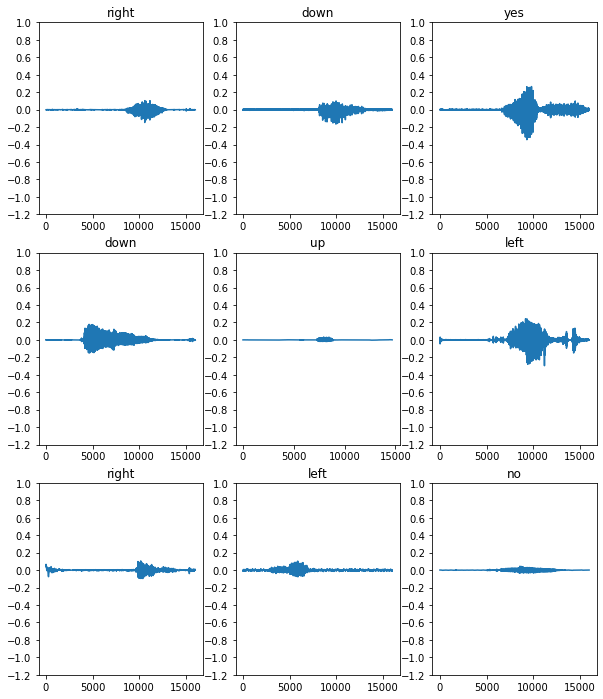

In [11]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Спектрограммы

Блок с исследованием спектрограмм сигналов

In [12]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [13]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)


print(tf.shape(waveform))

d = tf.shape(waveform)
test = tf.cast(AudioSegment.silent(duration = (16000 - d) * 1000 / 22050, frame_rate = 22050).get_array_of_samples(), tf.float32)

print(test.shape)

waveform = tf.cast(waveform, tf.float32)
wp = tf.concat([waveform, test], 0)

print(tf.shape(wp))

wp = tf.cast(wp, tf.float32)



tf.Tensor([16000], shape=(1,), dtype=int32)
(0,)
tf.Tensor([16000], shape=(1,), dtype=int32)


In [14]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

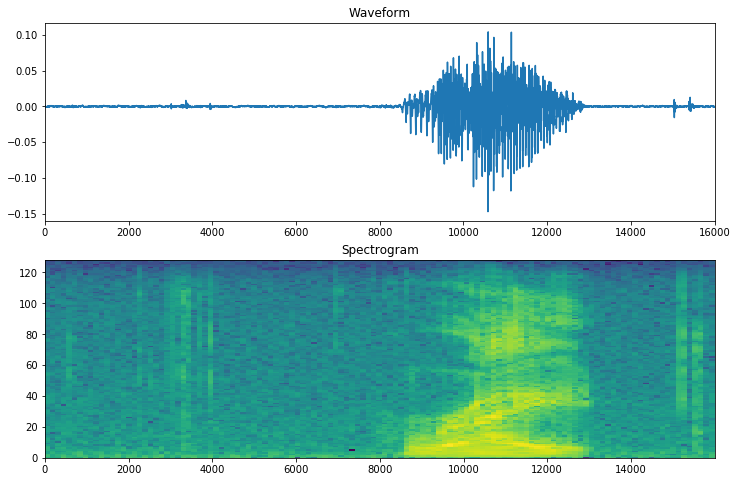

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [17]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [18]:
formant_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

Спектрограммы различных сигналов + паддинг

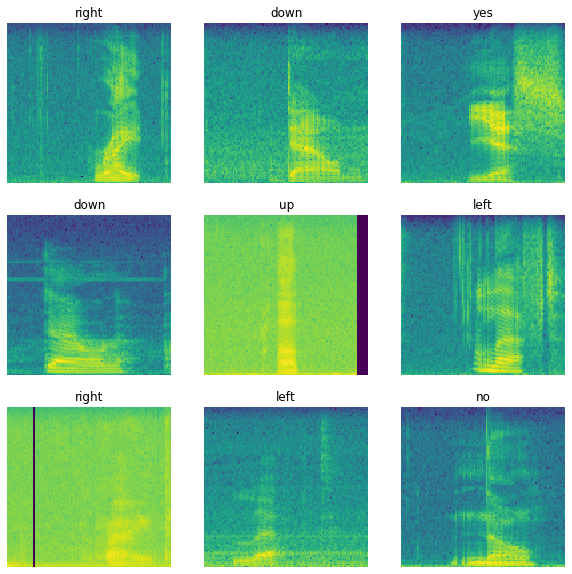

In [19]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(formant_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

## Извлечение фичей
Представлены 2 варианта подготовки фичей
1) из полученных STFT выбираются три максимальных пика. Далее из всего вектора STFT извлекаются окрестности пиков, остальные параметры зануляются - подготовленный вектор отправляется на вход нейронной сети
2) Во втором варианте - из пиковых значений выбираются три агрегированных характеристики - среднее, дисперсия и положение в спектре, таким образом на вход нейронной сети на каждый слайс подается 9 значений

In [20]:
def get_fourier(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    wave_stft = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    wave_stft = tf.abs(wave_stft)
    return wave_stft

In [57]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  feat_ = get_fourier(waveform)
  print(label, feat_[:1])

right tf.Tensor(
[[1.35076344e-02 2.74385456e-02 2.21273247e-02 6.31847326e-03
  5.71897347e-03 1.38533181e-02 1.51643241e-02 1.22679360e-02
  5.09187067e-03 1.12775469e-03 6.18132483e-03 9.65016149e-03
  7.86815211e-03 4.90655331e-03 3.04964767e-03 1.01132179e-03
  3.03281029e-03 6.14139950e-03 5.22267446e-03 4.91034938e-03
  5.51148597e-03 1.35603244e-03 2.50687590e-03 2.48863897e-03
  2.13877601e-03 1.34250033e-03 1.00290729e-03 2.01165630e-03
  2.54015555e-03 4.43899073e-03 4.93762409e-03 2.74511147e-03
  8.27924523e-04 2.21251929e-03 2.21581338e-03 4.29186504e-03
  4.89391061e-03 4.89158882e-03 4.79541300e-03 5.25469100e-03
  4.98941867e-03 2.17112736e-03 1.16304646e-03 1.42436929e-03
  1.75333768e-03 2.46883556e-03 9.51801543e-04 7.35883601e-04
  2.39828252e-03 1.67040701e-03 2.38405215e-03 3.03955493e-03
  2.69843987e-03 4.36146883e-03 5.59766684e-03 3.68764205e-03
  1.51744485e-03 1.45917980e-03 1.53993384e-03 8.97835067e-04
  7.90104677e-04 1.44486281e-03 7.91997707e-04 9.9913

[  1   6  11  17  20  22  30  36  39  45  48  51  54  58  61  64  67  72
  76  79  84  88  91  93  96 102 105 107 109 115 118 121 126]


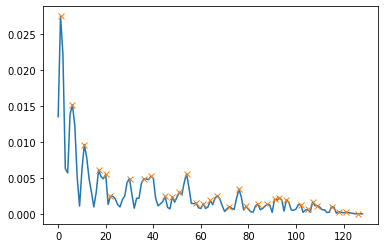

In [58]:

x = feat_[:1].numpy().flatten()

peaks, properties = find_peaks(x, height=0)
#peaks = peaks[0::2]
print(peaks)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.show()


In [83]:
def local_extract_peaks(arr):
    peaks, properties = find_peaks(arr, height = 0)
    
    arr_inp = np.zeros(arr.shape)
    arr_inp.put(peaks, arr[peaks])

    ind = np.argpartition(arr_inp, -3)[-3:]

    ind_full = list(ind)

    for i in ind:
        # print(i)
        for k in range(-5, 6):
            if k != 0 and i + k >= 0 and i + k <= 128:
                ind_full.append(i + k)
    arr_out = np.zeros(arr.shape)
    arr_out.put(ind_full, arr[ind_full])
    return arr_out, ind


Иллюстрация разметки пиков

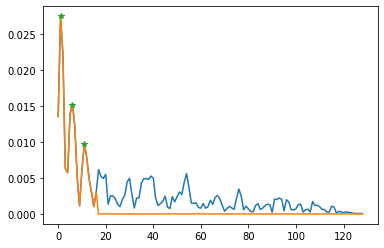

In [84]:
z = feat_[:1].numpy().flatten()
x, ind = local_extract_peaks(z)
plt.plot(z)
plt.plot(x)
plt.plot(ind, x[ind], "*")
plt.show()

In [127]:
def gaussian_fit(arr, index_):
    left = arr[max(0,index_-5):index_]
    right= arr[index_:5+index_+1]

    arr_in = np.concatenate((left, right), axis = 0)
    
    
    # print(arr_in)
    avg = np.mean(arr_in)
    var = np.var(arr_in)
    pdf_x = np.linspace(max(index_ - 5, 0), min(index_ + 5, arr.shape[0]), num = 11)
    pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
    # print(pdf_x, pdf_y)
    return avg, var, pdf_x, pdf_y



Извлечение агрегированных статистик

[0.01516432 0.01226794 0.00509187 0.00112775 0.00618132 0.00965016
 0.00786815 0.00490655 0.00304965 0.00101132 0.00303281]
[ 6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
11 0.006304714267819442 1.8841077458658697e-05
[0.02743855 0.02212732 0.00631847 0.00571897 0.01385332 0.01516432
 0.01226794 0.00509187 0.00112775 0.00618132 0.00965016]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6 0.011358182443390515 5.699431129078732e-05
[0.01350763 0.02743855 0.02212732 0.00631847 0.00571897 0.01385332
 0.01516432]
[0.  0.6 1.2 1.8 2.4 3.  3.6 4.2 4.8 5.4 6. ] [6.779475 0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.      ]
1 0.014875513368419238 5.292615612365431e-05


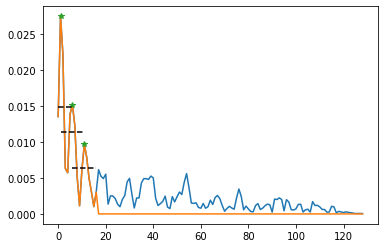

In [86]:
z = feat_[:1].numpy().flatten()
x, ind = local_extract_peaks(z)
plt.plot(z)
plt.plot(x)
plt.plot(ind, x[ind], "*")

for i in ind:
    m, d, xx, y = gaussian_fit(x, i)
    print(i, m, d)
    plt.plot(xx, np.full(xx.shape, m), 'k--')
    # plt.plot(xx, y, 'k--')
plt.show()

In [87]:
def filter_peaks_stft(arr):
    arr_, _ = local_extract_peaks(arr)
    return arr_

In [88]:
def filter_peaks_stft_apply(waveform, label):
    inp_arr = waveform.numpy()
    features_init = get_fourier(waveform)
    features = tf.convert_to_tensor(np.apply_along_axis(filter_peaks_stft, 1, features_init), dtype=tf.float32)
    
    label_id = tf.argmax(label == commands)
    #print('label_id : ', label_id, ' features : ', features.shape)
    del inp_arr

    return features, label_id

In [89]:
for waveform, label in files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE).take(1):
  label = label.numpy().decode('utf-8')
  f_, l_ = filter_peaks_stft_apply(waveform, label)
  print(f_.shape, l_.shape)



(124, 129) ()


In [90]:
def filter_peaks_stft_outside_function(waveform, label):
    wv, lbl = tf.py_function(func = filter_peaks_stft_apply, inp = [waveform, label], Tout = [tf.float32, tf.int64])
    wv = tf.reshape(wv, shape=(15996,))
    return wv, lbl


In [91]:
for waveform, label in files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE).take(1):
  wv, label_ = filter_peaks_stft_outside_function(waveform, label)
  print(wv.shape, label_)

(15996,) tf.Tensor(4, shape=(), dtype=int64)


In [92]:
def filter_peaks_stft_preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label)
  output_ds = output_ds.map(filter_peaks_stft_outside_function)
  #output_ds = output_ds.map(fix_shape_)
  return output_ds

In [93]:
train_ds = filter_peaks_stft_preprocess_dataset(train_files)
val_ds = filter_peaks_stft_preprocess_dataset(val_files)
test_ds = filter_peaks_stft_preprocess_dataset(test_files)

whole_ds = filter_peaks_stft_preprocess_dataset(filenames)

In [94]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [95]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
print(train_ds.take(1))

<TakeDataset shapes: ((None, 15996), <unknown>), types: (tf.float32, tf.int64)>


### Инициализация и обучение модели (Full Dense-NN) над отфильтрованными STFT

Размерность входного слоя - 129 * 124 (размерность STFT x количество окон)

In [96]:
for elem, _ in whole_ds.take(1):
  input_shape = elem.shape
print('Input shape:', input_shape)
num_labels = len(commands)
print(num_labels)

Input shape: (15996,)
8


In [98]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(15996, activation='relu', name = 'dense_init'),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu', name = 'dense_256'),
    layers.Dropout(0.15),
    layers.Dense(128, activation='relu', name = 'dense_128'),
    layers.Dropout(0.15),
    layers.Dense(64, activation='relu', name = 'dense_64'),
    layers.Dropout(0.15),
    layers.Dense(num_labels, activation = 'softmax', name = 'softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_init (Dense)          (None, 15996)             255888012 
                                                                 
 dropout_12 (Dropout)        (None, 15996)             0         
                                                                 
 dense_256 (Dense)           (None, 256)               4095232   
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_128 (Dense)           (None, 128)               32896     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_64 (Dense)            (None, 64)               

In [99]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.CategoricalAccuracy()
)

In [100]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 1370s 14s/step - loss: 2.6501 - categorical_accuracy: 0.0656 - val_loss: 1.7206 - val_categorical_accuracy: 0.0625
Epoch 2/10
100/100 [==============================] - 941s 9s/step - loss: 1.6687 - categorical_accuracy: 0.0820 - val_loss: 1.4840 - val_categorical_accuracy: 0.0712
Epoch 3/10
100/100 [==============================] - 947s 9s/step - loss: 1.4964 - categorical_accuracy: 0.0723 - val_loss: 1.2973 - val_categorical_accuracy: 0.0787
Epoch 4/10
100/100 [==============================] - 992s 10s/step - loss: 1.3409 - categorical_accuracy: 0.0767 - val_loss: 1.2433 - val_categorical_accuracy: 0.0800
Epoch 5/10
100/100 [==============================] - 1415s 14s/step - loss: 1.1822 - categorical_accuracy: 0.0720 - val_loss: 1.1517 - val_categorical_accuracy: 0.0737
Epoch 6/10
100/100 [==============================] - 1359s 14s/step - loss: 1.0712 - categorical_accuracy: 0.0791 - val_loss: 1.2196 - val_categorical_accuracy

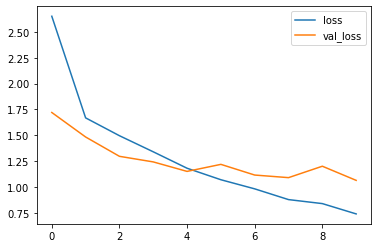

In [101]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

### Тестирование

In [102]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [103]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 68%


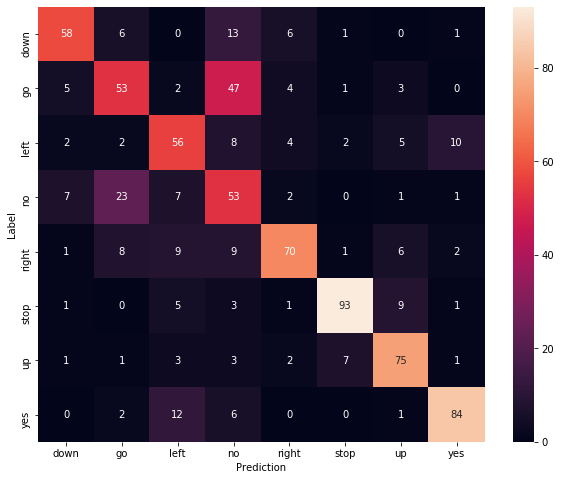

In [104]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

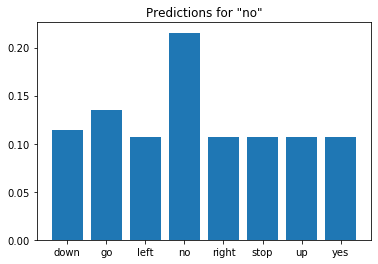

In [106]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = filter_peaks_stft_preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

# Извлечение фичей вида "положение - среднее - дисперсия"

In [155]:
def extract_agg_gaussian(arr):
    arr_, ind_ = local_extract_peaks(arr)
    out_list = []
    for i in np.sort(ind_):
        mean_, var_, _, _ = gaussian_fit(arr_, i)
        out_list.append(mean_)
        out_list.append(var_)
        out_list.append(i / 128)
    
    return np.array(out_list)

In [157]:
print(extract_agg_gaussian(feat_[:1].numpy().flatten()))

[1.48755134e-02 5.29261561e-05 7.81250000e-03 1.13581824e-02
 5.69943113e-05 4.68750000e-02 6.30471427e-03 1.88410775e-05
 8.59375000e-02]


In [158]:
def agg_gaussian_apply(waveform, label):
    inp_arr = waveform.numpy()
    features_init = get_fourier(waveform)
    features = tf.convert_to_tensor(np.apply_along_axis(extract_agg_gaussian, 1, features_init), dtype=tf.float32)
    
    label_id = tf.argmax(label == commands)
    
    del inp_arr

    return features, label_id

In [161]:
def agg_gaussian_outside_function(waveform, label):
    wv, lbl = tf.py_function(func = agg_gaussian_apply, inp = [waveform, label], Tout = [tf.float32, tf.int64])
    wv = tf.reshape(wv, shape=(1116,))
    return wv, lbl

In [162]:
for waveform, label in files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE).take(1):
  wv, label_ = agg_gaussian_outside_function(waveform, label)
  print(wv.shape, label_)

(1116,) tf.Tensor(4, shape=(), dtype=int64)


In [177]:
def agg_gauss_preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label)
  output_ds = output_ds.map(agg_gaussian_outside_function)
  #output_ds = output_ds.map(fix_shape_)
  return output_ds

In [178]:
gauss_train_ds = agg_gauss_preprocess_dataset(train_files)
gauss_val_ds = agg_gauss_preprocess_dataset(val_files)
gauss_test_ds = agg_gauss_preprocess_dataset(test_files)

gauss_whole_ds = agg_gauss_preprocess_dataset(filenames)

In [179]:
batch_size = 16
gauss_train_ds = gauss_train_ds.batch(batch_size)
gauss_val_ds = gauss_val_ds.batch(batch_size)

In [180]:
gauss_train_ds = gauss_train_ds.cache().prefetch(AUTOTUNE)
gauss_val_ds = gauss_val_ds.cache().prefetch(AUTOTUNE)
print(gauss_train_ds.take(1))

<TakeDataset shapes: ((None, 1116), <unknown>), types: (tf.float32, tf.int64)>


In [181]:
for elem, _ in gauss_whole_ds.take(1):
  input_shape = elem.shape
print('Input shape:', input_shape)
num_labels = len(commands)
print(num_labels)

Input shape: (1116,)
8


### Обучение модели

Размерность входного вектора - 1116 (124 * 9 - количество окон X количество фичей)

In [182]:
model_g = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(512, activation='relu', name = 'dense_init'),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu', name = 'dense_256'),
    layers.Dropout(0.15),
    layers.Dense(128, activation='relu', name = 'dense_128'),
    layers.Dropout(0.15),
    layers.Dense(64, activation='relu', name = 'dense_64'),
    layers.Dropout(0.15),
    layers.Dense(num_labels, activation = 'softmax', name = 'softmax')
])

model_g.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_init (Dense)          (None, 512)               571904    
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_256 (Dense)           (None, 256)               131328    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_128 (Dense)           (None, 128)               32896     
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_64 (Dense)            (None, 64)               

In [183]:
model_g.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.CategoricalAccuracy()
)

In [184]:
EPOCHS = 10
history = model_g.fit(
    gauss_train_ds, 
    validation_data=gauss_val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


<ipython-input-127-bb72c0793cbd>:12: RuntimeWarning: divide by zero encountered in double_scalars
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-127-bb72c0793cbd>:12: RuntimeWarning: divide by zero encountered in true_divide
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-127-bb72c0793cbd>:12: RuntimeWarning: invalid value encountered in multiply
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)


400/400 [==============================] - 607s 2s/step - loss: 2.3077 - categorical_accuracy: 0.0988 - val_loss: 1.8706 - val_categorical_accuracy: 0.0887
Epoch 2/10
400/400 [==============================] - 3s 8ms/step - loss: 1.8360 - categorical_accuracy: 0.1036 - val_loss: 1.6148 - val_categorical_accuracy: 0.0812
Epoch 3/10
400/400 [==============================] - 3s 8ms/step - loss: 1.6377 - categorical_accuracy: 0.0939 - val_loss: 1.5183 - val_categorical_accuracy: 0.0825
Epoch 4/10
400/400 [==============================] - 3s 7ms/step - loss: 1.5148 - categorical_accuracy: 0.0922 - val_loss: 1.3982 - val_categorical_accuracy: 0.0775
Epoch 5/10
400/400 [==============================] - 3s 7ms/step - loss: 1.4295 - categorical_accuracy: 0.0898 - val_loss: 1.3897 - val_categorical_accuracy: 0.0775
Epoch 6/10
400/400 [==============================] - 3s 7ms/step - loss: 1.3543 - categorical_accuracy: 0.0869 - val_loss: 1.3544 - val_categorical_accuracy: 0.0862
Epoch 7/10
400

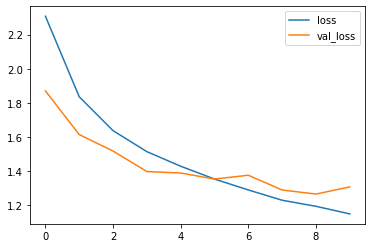

In [185]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [191]:
test_audio = []
test_labels = []

for audio, label in gauss_test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

<ipython-input-127-bb72c0793cbd>:12: RuntimeWarning: divide by zero encountered in double_scalars
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-127-bb72c0793cbd>:12: RuntimeWarning: divide by zero encountered in true_divide
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)
<ipython-input-127-bb72c0793cbd>:12: RuntimeWarning: invalid value encountered in multiply
  pdf_y = (1.0/np.sqrt(2*np.pi*var))*np.exp(-0.5*(pdf_x-avg)**2/var)


In [192]:
y_pred = np.argmax(model_g.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 52%


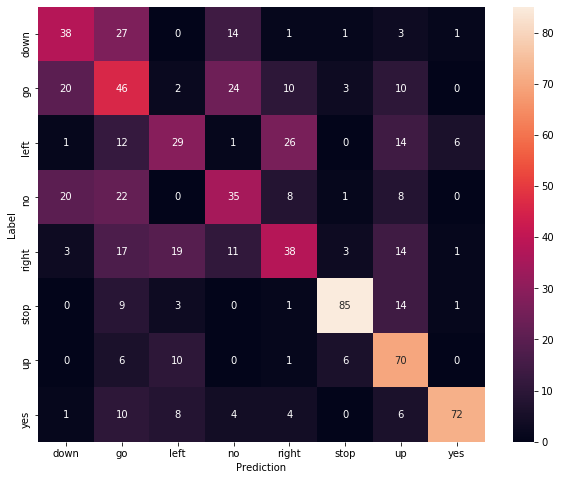

In [193]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

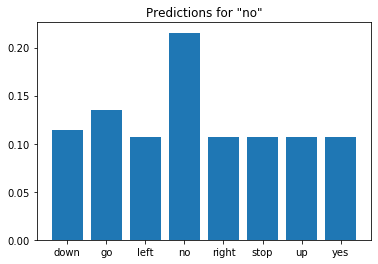

In [194]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = filter_peaks_stft_preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()